In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from fredapi import fred

In [8]:
# List of Treasury yield series IDs on FRED
tenor_series_ids = [
    "DGS1MO", "DGS3MO", "DGS6MO", "DGS1",  # Short-term yields
    "DGS2", "DGS3", "DGS5",               # Medium-term yields
    "DGS7", "DGS10", "DGS20", "DGS30"     # Long-term yields
]

In [22]:
def fetch_fred_yield(tenors = tenor_series_ids, start_date="2023-01-01", end_date="2023-12-31", api_key="af8df0010991ac8ed7cc64e3f1f74429"):
    # Define the API URL and parameters here
    
    # Make an API request and handle errors
    
    # Convert response JSON into a DataFrame, setting 'date' as index
    # Convert the 'value' column to numeric and rename it based on series_id
    url = "https://api.stlouisfed.org/fred/series/observations"
    all_tenors = {}
    for tenor in tenors:
        params = {
            "series_id": tenor,
            "api_key": api_key,
            "file_type": "json",
            "obsrvation_start": start_date,
            "obsrvation_end": end_date
        }
        response = requests.get(url, params = params)
        data = response.json()
        observations = data['observations']
        df = pd.DataFrame(observations)
        all_tenors[tenor] = df.set_index("date")["value"]
    
    df = pd.concat(all_tenors.values(), axis=1)
    df.columns = tenors
    df.index.name = "date"
    
    return df # Final DataFrame with date index and yield column

In [46]:
all_yields = fetch_fred_yield()
all_yields = all_yields.apply(pd.to_numeric, errors='coerce') 
all_yields.dropna(inplace=True)
all_yields.head()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
date,,,,,,,,,,,
2001-07-31,3.67,3.54,3.47,3.53,3.79,4.06,4.57,4.86,5.07,5.61,5.51
2001-08-01,3.65,3.53,3.47,3.56,3.83,4.09,4.62,4.90,5.11,5.63,5.53
2001-08-02,3.65,3.53,3.46,3.57,3.89,4.17,4.69,4.97,5.17,5.68,5.57
2001-08-03,3.63,3.52,3.47,3.57,3.91,4.22,4.72,4.99,5.20,5.70,5.59
2001-08-06,3.62,3.52,3.47,3.56,3.88,4.17,4.71,4.99,5.19,5.70,5.59


In [48]:
all_yields.mean(axis=0)

DGS1MO    1.535873
DGS3MO    1.601332
DGS6MO    1.702814
DGS1      1.783351
DGS2      1.958795
DGS3      2.142654
DGS5      2.520513
DGS7      2.834690
DGS10     3.111882
DGS20     3.639001
DGS30     3.738874
dtype: float64

In [54]:
# Spread Calculations
bond_yields_path = 'data/Part 1. bonds_yields.xlsx'
bond_yields = pd.read_excel(bond_yields_path)

def calculate_spread(bond_yields = bond_yields, treasuries=all_yields):
    spreads = []
    yield_points = [0.083, 0.25, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0]
    avg_t_yields = treasuries.mean(axis=0)
    for _, bond in bond_yields.iterrows():
        wal = bond["WAL (years)"]
        # linear interpolation can be done using np.interp
        interpolated_yield = np.interp(wal, yield_points, avg_t_yields.values)
        spread = bond["Yield (%)"] - interpolated_yield
        spreads.append(spread)
    bond_yields["Spread"] = spreads
    
    return bond_yields
        

In [58]:
spreads = calculate_spread()
#spreads.head()

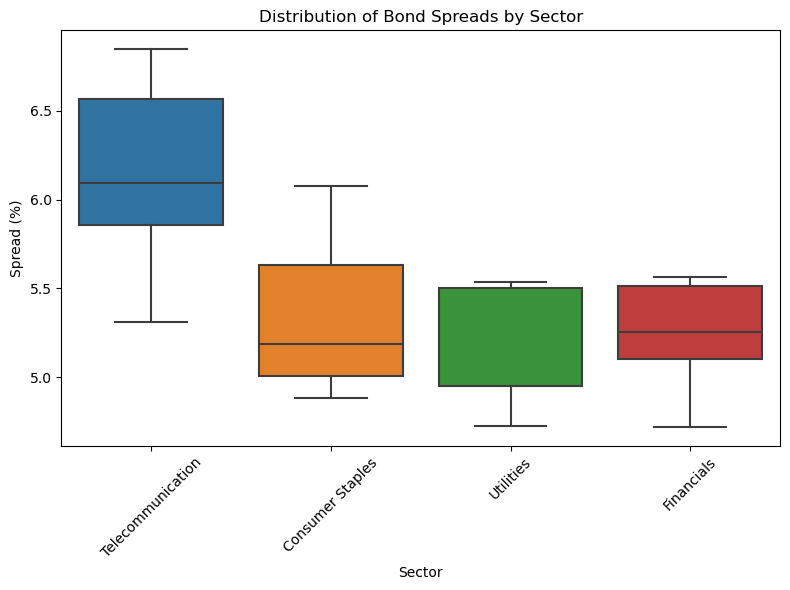

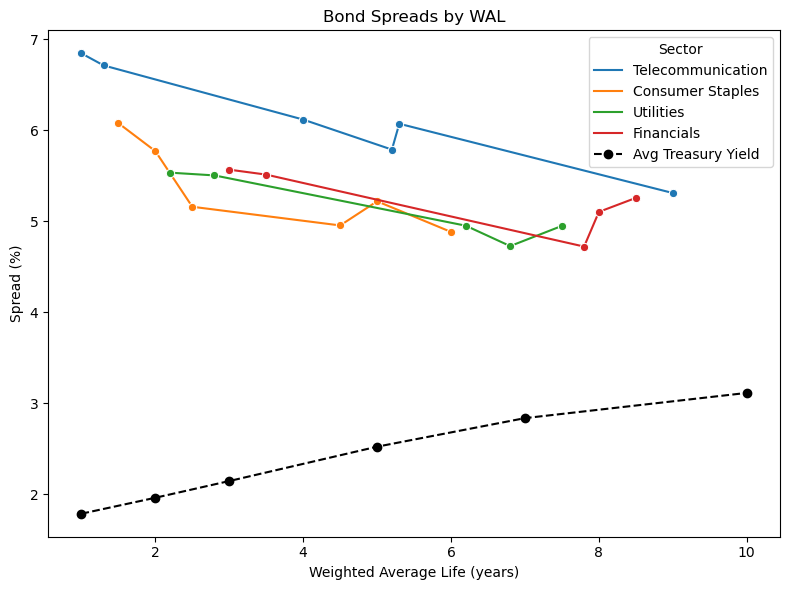

In [75]:
# Visualizations

# Let's see the spread distribution by sector, the ideal way may be a boxplot
plt.figure(figsize=(8,6))
sns.boxplot(data=spreads, x="Sector", y="Spread")
plt.title("Distribution of Bond Spreads by Sector")
plt.xlabel("Sector")
plt.ylabel("Spread (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Let's check out a scatterplot of spreads by WAL for each sector
yield_points = [1.0, 2.0, 3.0, 5.0, 7.0, 10.0]
mean_yield = all_yields.mean(axis=0)
plt.figure(figsize=(8,6))
sns.lineplot(data=spreads, x="WAL (years)", y="Spread", hue="Sector", marker="o")
plt.plot(yield_points, mean_yield.values[3:9], color="black",linestyle="--", marker="o", label="Avg Treasury Yield")
plt.title("Bond Spreads by WAL")
plt.xlabel("Weighted Average Life (years)")
plt.ylabel("Spread (%)")
plt.legend(title="Sector")
plt.tight_layout()
plt.show()

We can very easily omit the treasury curve for slightly cleaner visualization.
With its inclusion however, we can see that the spreads fall with longer average life.
This convergence suggests a declining risk premia associated with these bonds over longer average life
(which matches our intuition). Having more bonds in our datasets, and more datapoints might smoothen these curves
(if we apply smoothing). With the data we have we can still make reasonable visual comparisons by sector. Telecom has the highest spread
and perhaps the greatest perceived risk, the spreads of Consumer Staples bonds appears lower, however we do not have 
higher WAL bonds for this sector. Financials have a slight spike around the 8 year WAL (corresponding to bonds H and R 
in our dataset).

In [82]:
# Loan Default Prediction
part_2_path = "data/Part 2. loan_data_final.csv"
loan_data = pd.read_csv(part_2_path)
loan_data = loan_data.drop(['Unnamed: 0'], axis=1)
print(loan_data.info())
print(loan_data.describe())
loan_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  int64  
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  int64  
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_intent                     45000 non-null  object 
 7   loan_int_rate                   45000 non-null  float64
 8   loan_percent_income             45000 non-null  float64
 9   cb_person_cred_hist_length      45000 non-null  int64  
 10  credit_score                    45000 non-null  int64  
 11  previous_loan_defaults_on_file  45000 non-null  object 
 12  loan_to_income_ratio            

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_to_income_ratio,loan_type,dependents_count,regional_unemployment_rate,borrower_risk_score,loan_status
0,22,female,Master,71948,0,RENT,PERSONAL,16.02,0.49,3,561,No,0.49,FLOATING,3,6.84,281.4,1
1,21,female,High School,12282,0,OWN,EDUCATION,11.14,0.08,2,504,Yes,0.08,FIXED,0,5.96,252.4,0
2,25,female,High School,12438,3,MORTGAGE,MEDICAL,12.87,0.44,3,635,No,0.44,FIXED,0,6.69,318.4,1
3,23,female,Bachelor,79753,0,RENT,MEDICAL,15.23,0.44,2,675,No,0.44,FIXED,3,7.63,338.1,1
4,24,male,Master,66135,1,RENT,MEDICAL,14.27,0.53,4,586,No,0.53,FLOATING,0,4.63,294.2,1


In [85]:
loan_data.dropna(inplace=True)
loan_data.isnull().sum()
# No nulls
loan_data.drop_duplicates(inplace=True)

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Separate X, y, preprocess and then train test split
X = loan_data.drop(columns=["loan_status"])
y = loan_data["loan_status"]

# I looked up the column selection
cat_features = X.select_dtypes(include=["object"]).columns
numerical_features = X.select_dtypes(include=["float64", "int64"]).columns

preprocessor = ColumnTransformer(
    transformers = [
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=91)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

I was split between choosing a logistic Regression classification and Random Forest Classification.
I would do some more feature specific analysis (plotting, hypothesis testing) to try and determine feature importance before 
omitting features. I selected Random Forest due to its universality: we reduce the importance of less influential features
while identifying potentialnonlinear trends/relationsips. Random Forest is also a little more straightforward in hyperparameter tuning.

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [94]:
# If I had some more time I would have written the below pipeline into separate functions
model = RandomForestClassifier(random_state=39)

# Set up grid search for hyperparameter tuning

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=2) #potentially allow for parallel training
grid_search.fit(X_train, y_train)

print("Best Hyperparameters: \n", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   9.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   5.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   6.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   6.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  10.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  11.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  10.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  11.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   9.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=  14.9s
[CV] END max_depth=10, min_samples_split=2, n_es

In [97]:
from sklearn.metrics import accuracy_score, f1_score
# Evaluate model performance
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy:  {accuracy:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred, average='macro') # This (macro avg) was something I looked up
print(f"\F1 Score:  {accuracy:.4f}")

# Analyze Gini Impurity metric
gini_impurities = [tree.tree_.impurity for tree in best_model.estimators_]
# avg_gini_impurity = sum(gini_impurities) / len(gini_impurities)
# print("Average Gini Impurity across all trees: {avg_gini_impurity}")


 Confusion Matrix:
 [[10187   317]
 [  694  2302]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95     10504
           1       0.88      0.77      0.82      2996

    accuracy                           0.93     13500
   macro avg       0.91      0.87      0.89     13500
weighted avg       0.92      0.93      0.92     13500


Accuracy:  0.9251
\F1 Score:  0.9251


This was a fairly accurate model: best param set was {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Both precision and recall were good. Given some more fine tuning it is certainly possible to make this model even more robust.